#Traffic volume

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('/Users/polina/Desktop/bn_traffic/blocksnet/data/blocks.parquet')
blocks_gdf.head(2)

,geometry,site_area,capacity_convenience,capacity_cafe,capacity_mall,capacity_pharmacy,capacity_bank,capacity_fuel,capacity_pitch,capacity_playground,...,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse,capacity_machine_building_plant,population
id,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",804466.712114,208.0,0.0,2216.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,565.0
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",23173.129862,811.0,25.0,0.0,0.0,148.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0


In [2]:
# Extract only Vasilievskiy Island blocks
import osmnx as ox

local_crs = 32636
polygon = ox.geocode_to_gdf(f'R1114252', by_osmid=True).to_crs(local_crs)
blocks_gdf = gpd.overlay(blocks_gdf,polygon).copy()

In [3]:
# get number of services from capacity
capacity_cols = [c for c in blocks_gdf.columns if 'capacity' in c]

dfs = []
for cap in capacity_cols:
    temp = blocks_gdf[['geometry', cap]].copy()
    temp['count'] = temp[cap] / 100
    temp = temp[['count']]
    dfs.append(temp)
dfs[0].head()
blocks_gdf = blocks_gdf[['geometry','site_area','population']]

In [4]:
# add 'land_use' to blocks
blocks_lu = gpd.read_parquet('/Users/polina/Desktop/bn_traffic/blocksnet/data/blocks_lu')
blocks_gdf = blocks_gdf.merge(blocks_lu[['land_use']],left_index=True,right_on='id')
blocks_gdf.head()

,geometry,site_area,population,land_use
id,,,,
0,"POLYGON ((346685.483 6646350.603, 346676.980 6...",134733.388072,0.0,None
1,"POLYGON ((348082.192 6647278.535, 348027.067 6...",27118.318639,0.0,transport
2,"POLYGON ((346913.982 6645642.126, 346913.695 6...",191644.467990,0.0,recreation
3,"POLYGON ((347204.988 6646268.305, 347225.559 6...",71630.640218,1594.0,residential
4,"POLYGON ((346360.572 6645760.541, 346351.759 6...",311087.315399,524.0,recreation


In [5]:
# Get walk and drive graphs
import pickle
import momepy
with open("/Users/polina/Desktop/bn_traffic/blocksnet/data/graph.pkl", "rb") as f:
    G_drive = pickle.load(f)
n,e = momepy.nx_to_gdf(G_drive)

with open("/Users/polina/Desktop/bn_traffic/blocksnet/data/walk_graph.pkl", "rb") as f:
    G_walk = pickle.load(f)

In [6]:
# get accessibility matrices
from iduedu import get_adj_matrix_gdf_to_gdf
import numpy as np

drive_mx_length = get_adj_matrix_gdf_to_gdf(n.to_crs(local_crs), n.to_crs(local_crs), G_drive, "length_meter", dtype=np.float64)
drive_mx_time = get_adj_matrix_gdf_to_gdf(n.to_crs(local_crs), n.to_crs(local_crs), G_drive, "time_min", dtype=np.float64)
walk_mx_time = get_adj_matrix_gdf_to_gdf(blocks_gdf.to_crs(local_crs), n.to_crs(local_crs), G_walk, "time_min", dtype=np.float64)

In [7]:
# Get diversity and density attributes
from blocksnet.analysis.centrality import service_centrality

centrality_df = service_centrality(drive_mx_time, blocks_gdf, dfs, diversity_weight=10)
centrality_df.rename(columns={'shannon_diversity':'diversity'},inplace=True)
blocks = blocks_gdf.merge(centrality_df[['diversity', 'density']],left_on='id',right_index=True)
blocks.head()

/Users/polina/Desktop/bn_traffic/blocksnet/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


,geometry,site_area,population,land_use,diversity,density
id,,,,,,
0,"POLYGON ((346685.483 6646350.603, 346676.980 6...",134733.388072,0.0,None,0.000000,0.000000
1,"POLYGON ((348082.192 6647278.535, 348027.067 6...",27118.318639,0.0,transport,0.933239,0.009919
2,"POLYGON ((346913.982 6645642.126, 346913.695 6...",191644.467990,0.0,recreation,0.000000,0.000000
3,"POLYGON ((347204.988 6646268.305, 347225.559 6...",71630.640218,1594.0,residential,0.876972,0.000307
4,"POLYGON ((346360.572 6645760.541, 346351.759 6...",311087.315399,524.0,recreation,1.066590,0.000383


In [8]:
from blocksnet.analysis.network.traffic_volume import origin_destination_matrix, road_congestion
od_mx = origin_destination_matrix(blocks_gdf,n,walk_mx_time, drive_mx_length, local_crs)
new_graph = road_congestion(od_mx, G_drive)

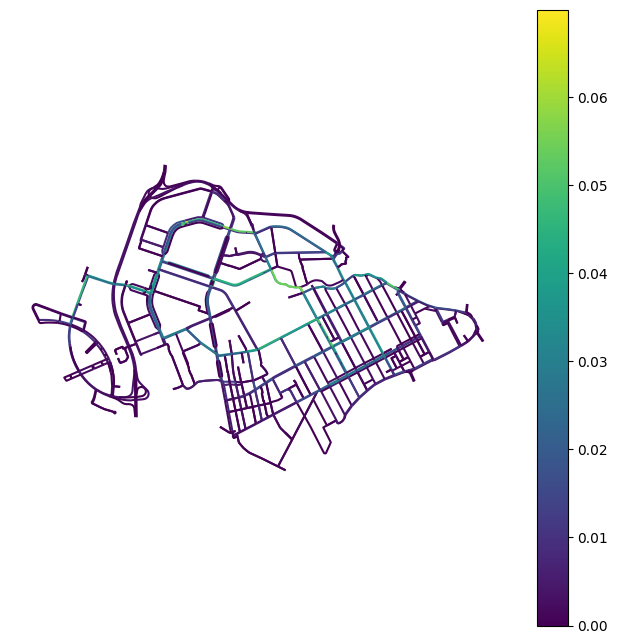

In [9]:
momepy.nx_to_gdf(new_graph)[1].plot('congestion', legend=True, figsize=(8, 8)).set_axis_off()